In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

from pipeline.utils import *
import pandas as pd
import pickle as pkl
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import PIL.Image as pil

In [2]:
# define pipeline objects
monodepth = Monodepth("monodepth", "../pipeline")
inpaint = Inapint("inpaint", "../pipeline")
transf = Transformation()

In [3]:
def pipeline(img: np.array, tx: float=0.0, ry: float=0.0):
    # convension
    tx, ry = -tx, -ry
    
    # transform image to tensor
    img = pil.fromarray(img)
    img = img.resize((512, 256))
    img = np.asarray(img)
    timg = img.transpose(2, 0, 1)
    timg = torch.tensor(timg).unsqueeze(0).float()

    # predict depth
    tdisp = monodepth.forward(timg)
    tdepth = monodepth.get_depth(tdisp)

    # shift image
    timg, tproj_img, tvalid_pts = transf.forward(timg, tdepth, tx=tx, ry=ry)

    img = timg.squeeze(0).numpy().transpose(1, 2, 0)
    img = img.astype(np.uint32)
    proj_img = tproj_img.squeeze(0).numpy().transpose(1, 2, 0)
    proj_img = proj_img.astype(np.uint32)

    # inpaint
    _, toutput = inpaint.forward(tproj_img.float(), tvalid_pts.float())
    output = toutput.squeeze(0).numpy().transpose(1, 2, 0)
    output = np.clip(255 * output, 0, 255).astype(np.uint8)
    return output

In [4]:
def worker(file: str, tx: float=0.0, ry: float=0.0):
    # read image
    img_path = "../dataset/imgs/" + file + ".png"
    img = np.asarray(pil.open(img_path))

    for x in tqdm(range(10)):
        img = pipeline(img, tx=tx/10.)
        plt.imshow(img)
        plt.show()
    

  0%|          | 0/10 [00:00<?, ?it/s]

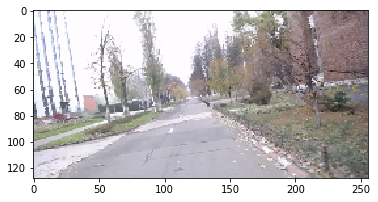

 10%|█         | 1/10 [00:47<07:03, 47.03s/it]

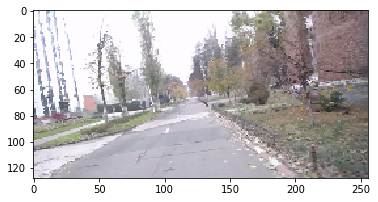

 20%|██        | 2/10 [01:38<06:28, 48.51s/it]

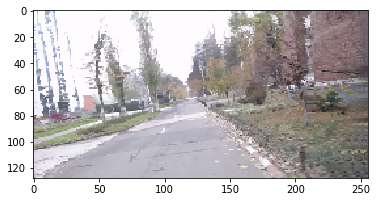

 30%|███       | 3/10 [02:30<05:45, 49.37s/it]

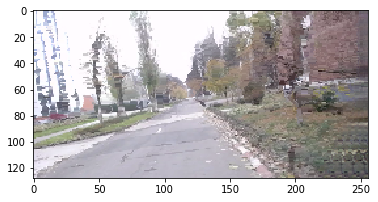

 40%|████      | 4/10 [03:16<04:51, 48.53s/it]

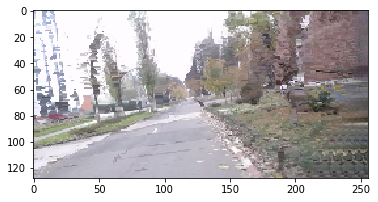

 50%|█████     | 5/10 [04:03<03:59, 47.86s/it]

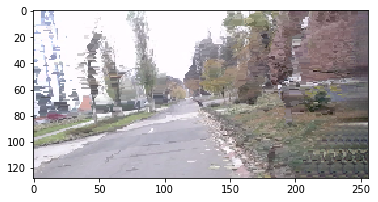

 60%|██████    | 6/10 [04:49<03:09, 47.49s/it]

KeyboardInterrupt: 

In [5]:
# read training files
train_files = list(pd.read_csv("../dataset/train.csv")["name"])[:1]

for file in train_files:
    worker(file, tx=2.0)